# Input and output
The output of a MCMC is a posterior, i.e., the probability distribution of parameter(s) of interest, **conditioned on the data, and a model/hypothesis**.

i.e., if you want to infer the mean `mu` of the data, then MCMC will give you a distribution of the `mu` (i.e., the belief of `mu`), given the data,some model selection, and a prior of mu. 

# Set up the problem
https://twiecki.io/blog/2015/11/10/mcmc-sampling/


## Data
We have some data sampled from a normal distribution (mean=0, std=2). The goal is to estimate the posterior of the mean, assuming that we know the std.

In [86]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm


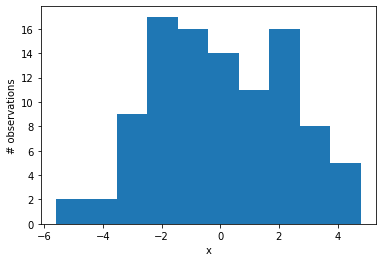

In [87]:
np.random.seed(123)
data_mu=0
data_sigma=2

data=np.random.normal(data_mu,data_sigma,100)
# plot the data
plt.hist(data)
plt.xlabel('x')
plt.ylabel('# observations')
plt.show()

When we have the data, we do not know that the data is normally distributed. However, let say we assumed that the data is normally distributed (with mean $\mu$ and standard deviation $\sigma$). In the first case, we assume that we know that $\sigma=2$. We only want to infer the mean $\mu$.

## Prior
Firstly, our prior of the mean $\mu$ is a also a Normal distribution with prior_mu=0, prior_sigma=1.

$$ \mu \sim \mathcal{N} (0,1)$$ 
$$ x|\mu \sim \mathcal{N} (x;\mu,2)$$

In [88]:
prior_mu=0
prior_sigma=1

### Compute the posterior analytically
We can compute the posterior analytically, because for a normal likelihood with known standard deviation, the normal prior for $\mu$ is conjugate (**conjugate here means that our posterior will follow the same distribution as the prior**), so we know that our posterior for μ is also normal. We can easily look up on wikipedia how we can compute the parameters of the posterior. 

## However
If our prior wasn't conjugate, then and we couldn't solve this by hand, which is usually the case.

# The logic of MCMC sampling
At first, you start with a arbitory guess, e.g., `mu_current=1`. Then you propose to move (jump) from current guess to somewhere else (The Markov part). There various ways to come up with this proposal. The **Metropolis samplers** just takes a sample from a normal distribution centered around you current mu value (i.e., `mu_current`), with a certain standard deviation (reffered as `proposal_width`) that will determine how far you propose jumps.

more fancy, MCMC algorithms like **Hamiltonian Monte Carlo** actually work very similar to this, they are just much more clever in proposing where to jump next.

In [89]:
mu_current=1

# make new guess
proposal_width=0.5
proposal=norm(mu_current, proposal_width).rvs()
print(proposal)

1.3210273446359158


Next, you evaluate if that is a good place to jump to or not. If the new `proposal` explain the data better than the old `mu`, then you want to go there. **what does 'explains the data better' mean?** We quantify by calculating the probability of the data given the likelihood with the proposed values (`mu=proposal, sigma=2` vs `mu=mu_current, sigma=2`).

In [90]:
# Assume that we know the data_sigma, only want to infet data_mu

# step 1: prior
# As mentioned, our prior of the data_mu is also a normal distribution (prior_mu, prior_sigma)
prior_current=norm(prior_mu,prior_sigma).pdf(mu_current)
prior_proposal=norm(prior_mu,prior_sigma).pdf(proposal)

# step 2:likelihood with mu_current vs proposal
likelihood_current=norm(mu_current,data_sigma).pdf(data).prod()
likelihood_proposal=norm(proposal,data_sigma).pdf(data).prod()


#Nominator of Bayes formula
p_current=prior_current*likelihood_current
p_proposal=prior_proposal*likelihood_proposal


Whether or not accept the `proposal` depends on the ratio between `p_current` and `p_proposal`. That is, definitely accept the `proposal` is `p_proposal` is much larger than the `p_current`.

In [91]:
p_accept=p_proposal/p_current
accept= np.random.rand()<p_accept
if accept:
    new_pos=proposal


$$\frac{ \frac{P(x|u_{proposal})P(u_{proposal})}{P(x)} } { \frac{P(x|u_{current})P(u_{current})}{P(x)} }=\frac{P(x|u_{proposal})P(u_{proposal})}{P(x|u_{current})P(u_{current}) }$$


Eq(1)

As you can see, the right side of Eq(1) is **`p_accept=p_proposal/p_current`. Therefore, `p_accept` is actually just the same as dividing the full posterior at one position by the full posterior at another position**. That way, we are visiting regions of high posterior probability relatively more often than those of low posterior probability.

**the samples that are generated in this way come from the posterior distribution of the model**

In [92]:
# put it together

def MCMC_sampler(data,n_samples=4, mu_init=0.5, proposal_width=0.5, prior_mu=0, prior_std=1.):
    data_sigma=2 # we assume that we know
    mu_current=mu_init
    posterior=[mu_current]
    
    for i in range(n_samples):
        proposal=norm(mu_current, proposal_width).rvs()
        
        # step 1: prior
        prior_current=norm(prior_mu,prior_sigma).pdf(mu_current)
        prior_proposal=norm(prior_mu,prior_sigma).pdf(proposal)
        
        # step 2:likelihood with mu_current vs proposal
        likelihood_current=norm(mu_current,data_sigma).pdf(data).prod()
        likelihood_proposal=norm(proposal,data_sigma).pdf(data).prod()
        
        #Nominator of Bayes formula
        p_current=prior_current*likelihood_current
        p_proposal=prior_proposal*likelihood_proposal

        
        p_accept=p_proposal/p_current
        accept= np.random.rand()<p_accept
        if accept:
            mu_current=proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)




Text(0.5, 1.0, 'this is usually called the trace')

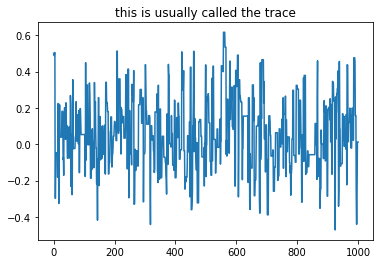

In [93]:
# generate s_samples from the posterior 

n_samples=1000
posterior=MCMC_sampler(data,n_samples)

plt.plot(posterior)
plt.title('this is usually called the trace')

To get an approximation of the posterior (to infer the mean of the data, as we said at the beginning), we take the histogram of this trace. The below plot is our belief in `data_mu`.

Text(0.5, 1.0, 'estimated posterior')

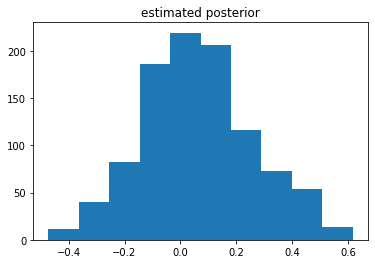

In [94]:
plt.hist(posterior)
plt.title('estimated posterior')

## How to choose the `proposal_width`?
 In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a long time to explore the whole parameter space and shows the typical random-walk behavior. But you also don't want it to be so large that you never accept a jump. Obviously we want to have a smart way of figuring out the right step width automatically. **One common method is to keep adjusting the proposal width so that roughly 50% proposals are rejected**.

(array([ 42., 105., 177., 117., 138., 161., 110.,  71.,  60.,  20.]),
 array([0.20801874, 0.24114749, 0.27427623, 0.30740498, 0.34053373,
        0.37366247, 0.40679122, 0.43991997, 0.47304871, 0.50617746,
        0.5393062 ]),
 <BarContainer object of 10 artists>)

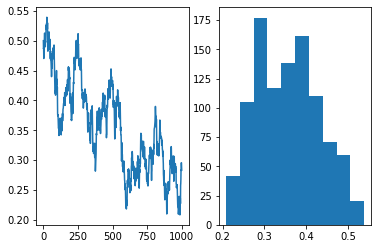

In [95]:
# too small of proposal_width
posterior=MCMC_sampler(data,n_samples,proposal_width=0.01)
plt.subplot(1,2,1)
plt.plot(posterior)
plt.subplot(1,2,2)
plt.hist(posterior)

(array([  5.,  72., 250., 293., 215., 142.,   9.,  14.,   0.,   1.]),
 array([-0.51336208, -0.36202587, -0.21068967, -0.05935346,  0.09198275,
         0.24331896,  0.39465517,  0.54599138,  0.69732758,  0.84866379,
         1.        ]),
 <BarContainer object of 10 artists>)

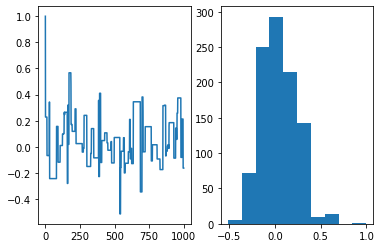

In [96]:
# too large of proposal_width
posterior=MCMC_sampler(data,n_samples,mu_init=1,proposal_width=3.)
plt.subplot(1,2,1)
plt.plot(posterior)
plt.subplot(1,2,2)
plt.hist(posterior)

# The successful jumps form a chain, called a Markov chain.

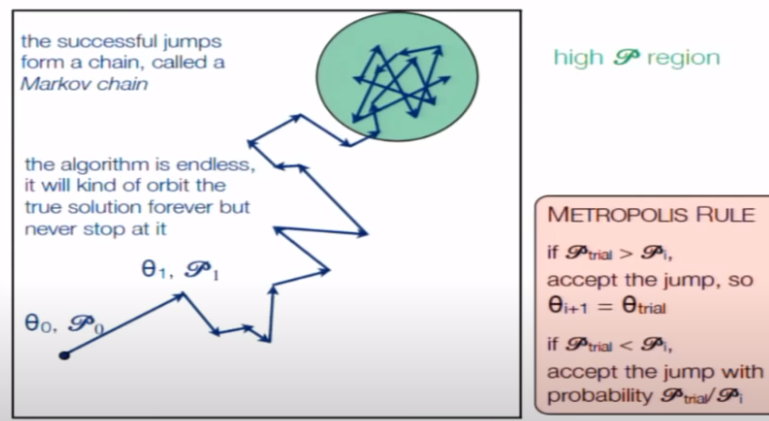

In [1]:
from IPython.display import Image
Image("imgs/MCMC.png")

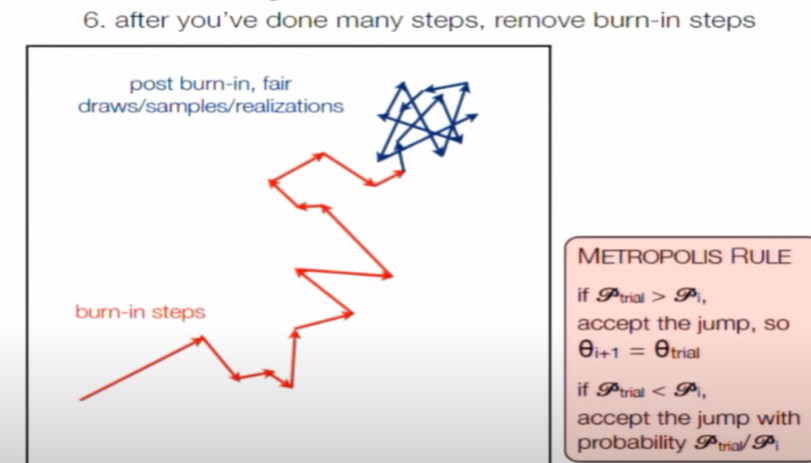

In [3]:
Image("imgs/MCMC2.png")